In [1]:
import pycocotools
import os
import json
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from matplotlib.patches import Polygon

In [2]:
# Plot some images with their annotations 
def plot_images_with_annotations(dataset, coco, n_images=3):
    images_shown = 0
    while images_shown < n_images:
        img_id = random.choice(coco.getImgIds())
        ann_ids = coco.getAnnIds(imgIds=img_id)
        if len(ann_ids) > 0:  # Check if there are annotations for the image
            img = coco.loadImgs(img_id)[0]
            image = cv2.imread(os.path.join(dataset, img['file_name']))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(img['file_name'])
            anns = coco.loadAnns(ann_ids)
            coco.showAnns(anns)
            plt.show()
            images_shown += 1

In [3]:
def plot_images_with_annotations_grid(dataset, coco, figsize=(20,15)):
    # Set grid dimensions
    rows, cols = 6, 3
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Get a random set of image IDs to display
    #img_ids = random.sample(coco.getImgIds(), rows * cols)
    images_shown = 0
    #img_ids = random.sample(range(len(coco.getImgIds())), rows * cols)
    saved_ids = []

    while images_shown < rows * cols:
        rand_id = random.randint(0, len(coco.getImgIds())-1)
        if rand_id in saved_ids:
            continue
        img = coco.loadImgs(rand_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img['id'])
        if len(ann_ids) > 0:  # Check if there are annotations for the image
            image = cv2.imread(os.path.join(dataset, img['file_name']))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Show image on current axis
            axes[images_shown].imshow(image_rgb)
            axes[images_shown].axis('off')

            # Get annotations for the current image
            anns = coco.loadAnns(ann_ids)

            # Manually draw annotations for each object
            for ann in anns:
                if 'segmentation' in ann:
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape((len(seg) // 2, 2))
                        polygon = Polygon(poly, fill=True, color='r', alpha=0.4)
                        axes[images_shown].add_patch(polygon)

            saved_ids.append(rand_id)
            images_shown += 1

    # Hide any unused subplots
    for j in range(images_shown, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def count_non_empty_annotations(coco):
    non_empty = 0
    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=img_id)
        if len(ann_ids) > 0:
            non_empty += 1
    return non_empty

# CA Dataset

In [5]:
ca_path = "../Fine_tuned_Detectron2/data/Dataset/Dataset_CA"
ca_images_path = os.path.join(ca_path, "images")
ca_json_path = os.path.join(ca_path, "coco_format.json")


# Load the COCO dataset
ca = COCO(ca_json_path)

ca.info()

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
year: 2023
version: 1
description: Micro Plastic Dataset
contributor: Felix
url: 
date_created: 12/11/23


In [6]:
print("Total images in the dataset: ", len(ca.getImgIds()))
print("Total categories in the dataset: ", len(ca.getCatIds()))

Total images in the dataset:  1287
Total categories in the dataset:  2


In [7]:
print("Images in category 1: ", len(ca.getImgIds(catIds=[1])))
print("Images in category 2: ", len(ca.getImgIds(catIds=[2])))

Images in category 1:  578
Images in category 2:  709


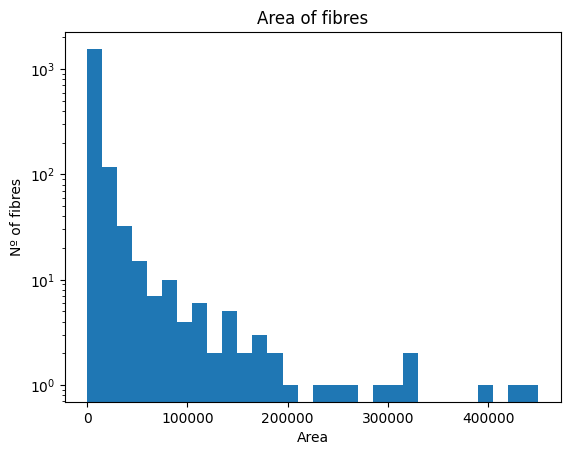

In [8]:
ca_area_anns = [ann['area'] for ann in ca.loadAnns(ca.getAnnIds())]
plt.hist(ca_area_anns, bins=30, log=True)
plt.xlabel('Area')
plt.ylabel('Nº of fibres')
plt.title('Area of fibres')
plt.show()

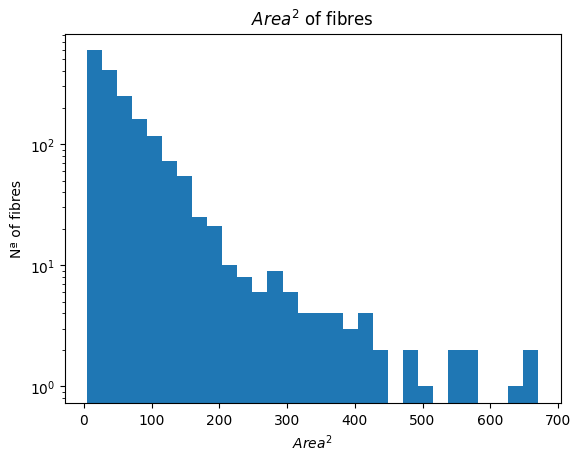

In [9]:
ca_area_squrd_anns = [ann['area']**0.5 for ann in ca.loadAnns(ca.getAnnIds())]
plt.hist(ca_area_squrd_anns, bins=30, log=True)
plt.xlabel('$Area^2$')
plt.ylabel('Nª of fibres')
plt.title('$Area^2$ of fibres')
plt.show()

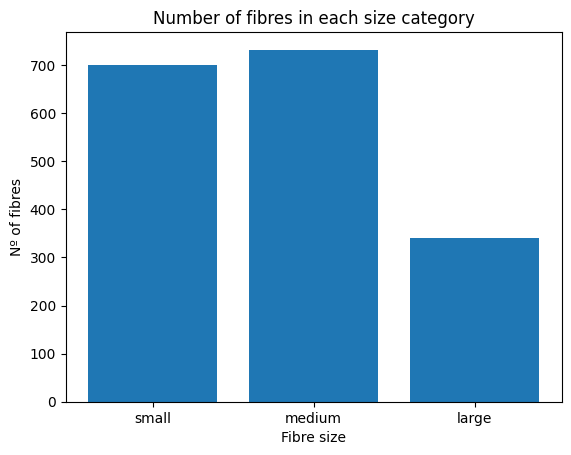

In [10]:
# Given that objects are small if their area < 32^2, medium if 32^2 < area < 96^2, and large if area > 96^2, we can plot the number of annotations in each category
small = 0
medium = 0
large = 0
for ann in ca.loadAnns(ca.getAnnIds()):
    if ann['area'] < 32**2:
        small += 1
    elif ann['area'] < 96**2:
        medium += 1
    else:
        large += 1

plt.bar(['small', 'medium', 'large'], [small, medium, large])
plt.xlabel('Fibre size')
plt.ylabel('Nº of fibres')
plt.title('Number of fibres in each size category')
plt.show()

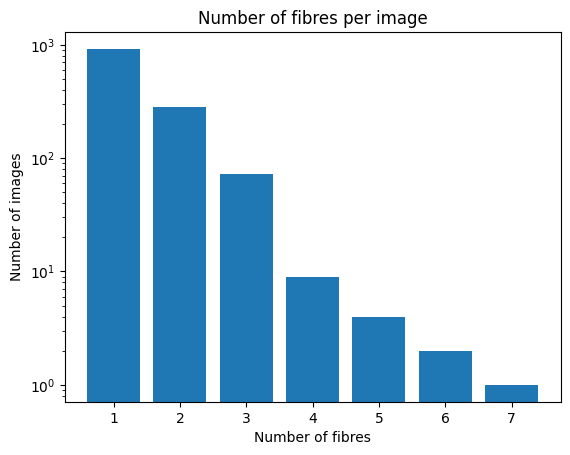

In [11]:
# Plot the number of annotations per image
anns_per_image = [len(ca.getAnnIds(imgIds=[img_id])) for img_id in ca.getImgIds()]
anns_count = [anns_per_image.count(i) for i in range(1, 8)]
plt.bar(range(1, 8), anns_count, log=True)
plt.xlabel('Number of fibres')
plt.ylabel('Number of images')
plt.title('Number of fibres per image')
plt.show()

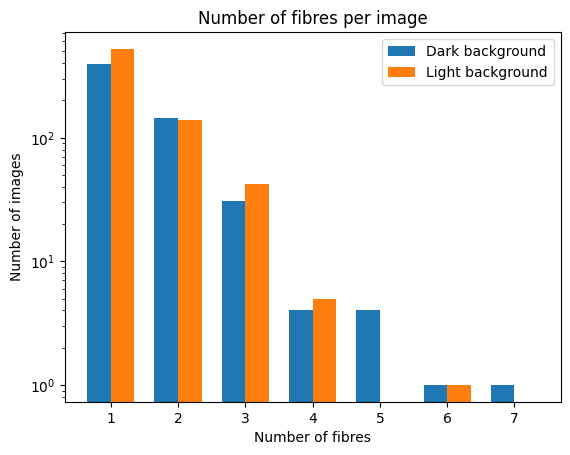

In [12]:
anns_per_image_cat1 = [len(ca.getAnnIds(imgIds=[img_id], catIds=[1])) for img_id in ca.getImgIds(catIds=[1])]
anns_per_image_cat2 = [len(ca.getAnnIds(imgIds=[img_id], catIds=[2])) for img_id in ca.getImgIds(catIds=[2])]

anns_count_cat1 = [anns_per_image_cat1.count(i) for i in range(1, 8)]
anns_count_cat2 = [anns_per_image_cat2.count(i) for i in range(1, 8)]

bar_width = 0.35
x = np.arange(1, 8)

plt.bar(x - bar_width/2, anns_count_cat1, width=bar_width, label='Dark background', log=True)
plt.bar(x + bar_width/2, anns_count_cat2, width=bar_width, label='Light background', log=True)

plt.xlabel('Number of fibres')
plt.ylabel('Number of images')
plt.title('Number of fibres per image')
plt.xticks(x)
plt.legend()
plt.show()


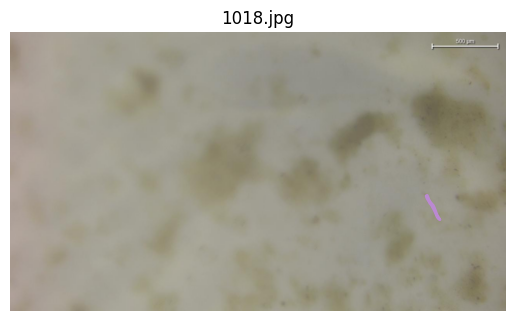

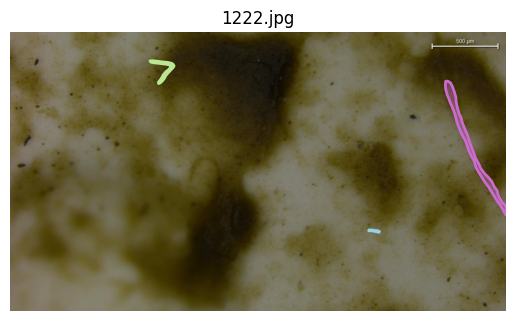

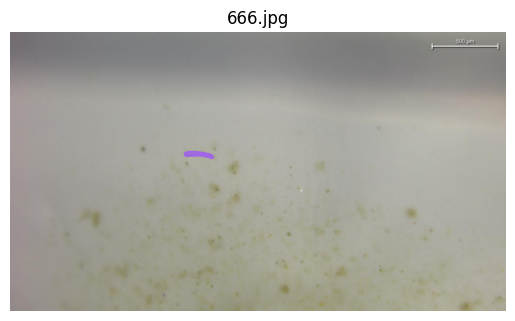

In [13]:
plot_images_with_annotations(ca_images_path, ca, n_images=3)

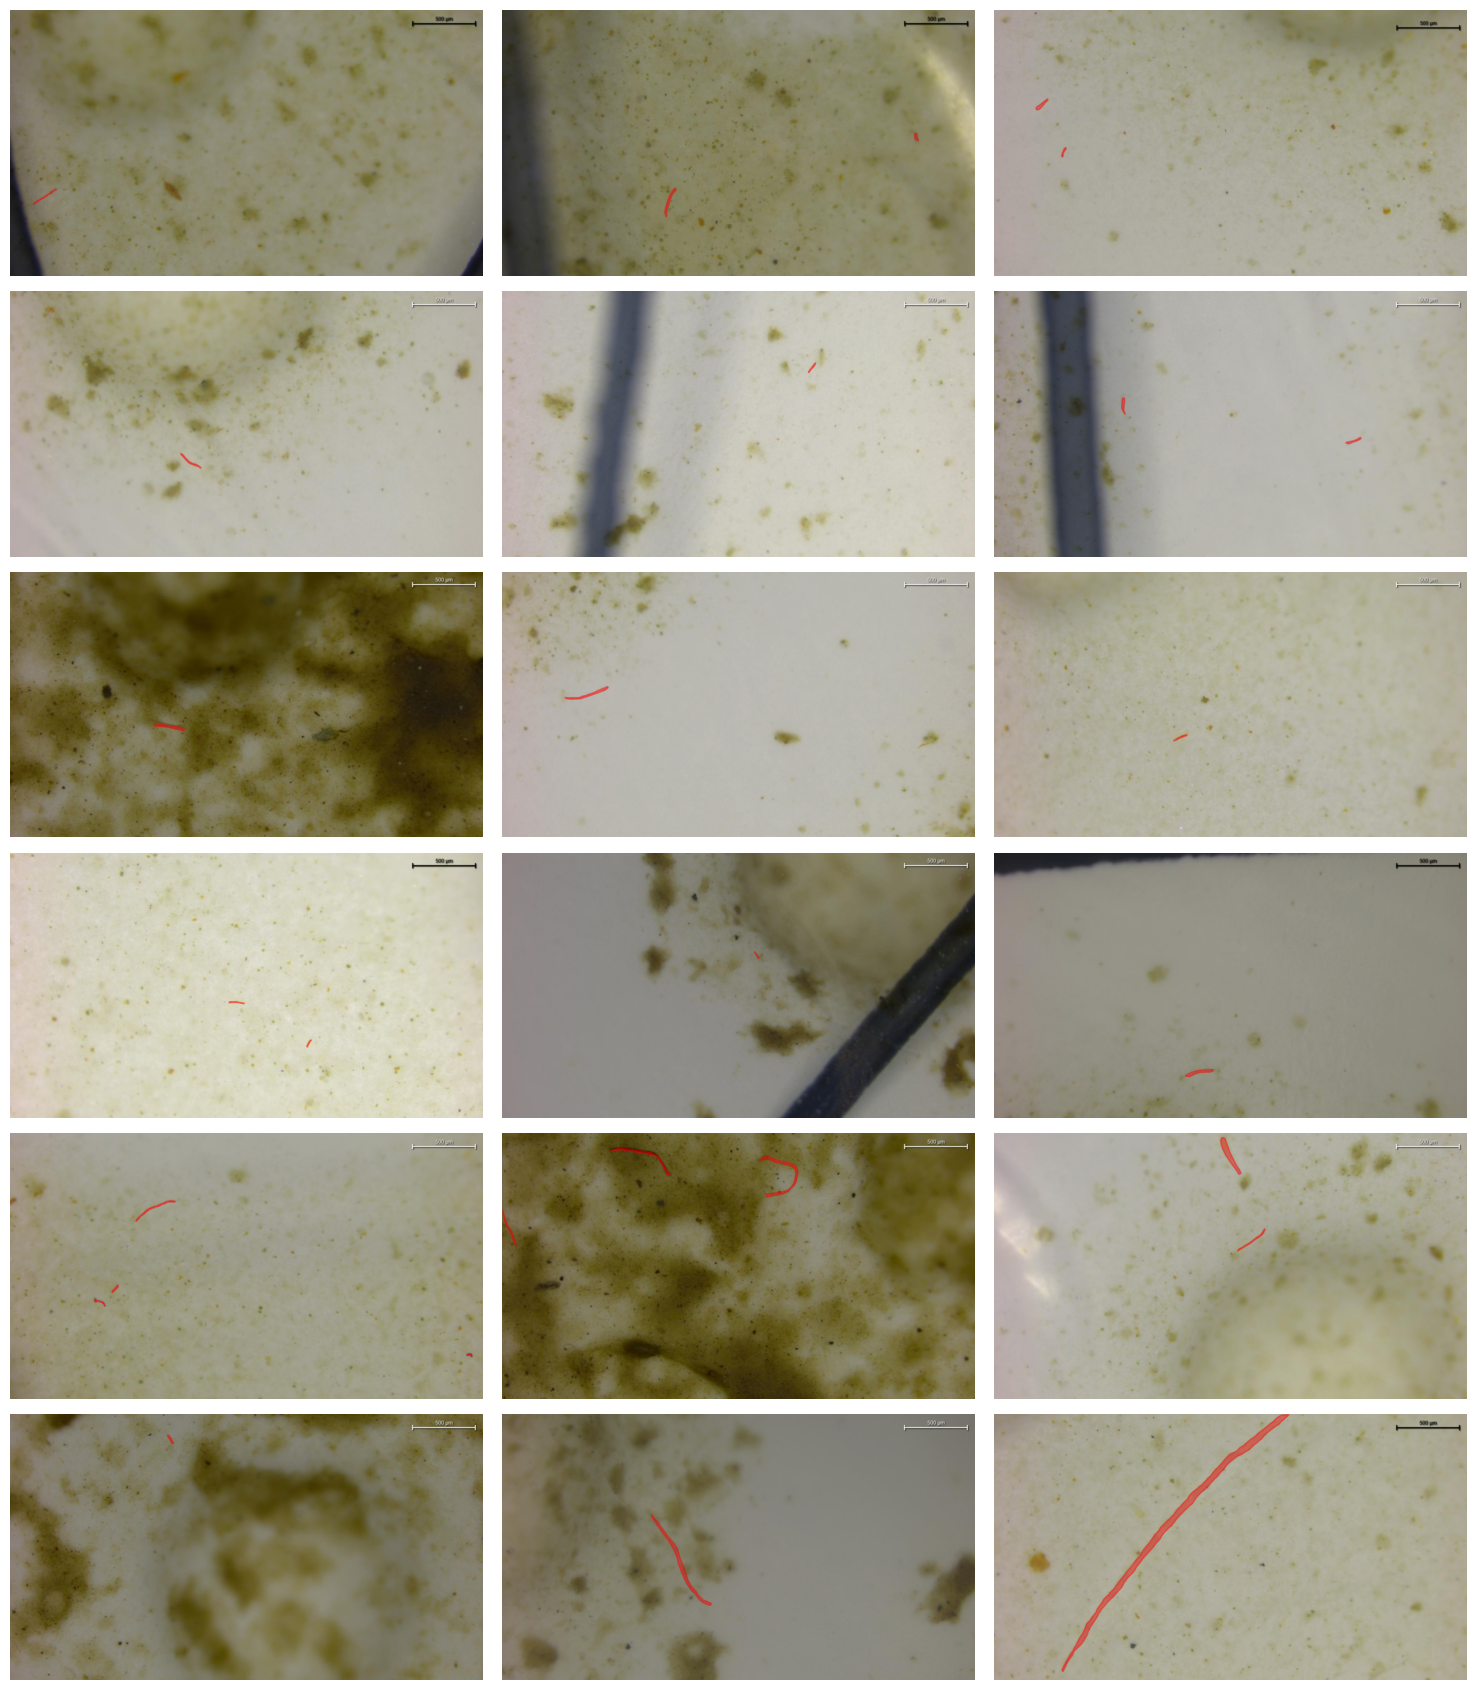

In [14]:
plot_images_with_annotations_grid(ca_images_path, ca, figsize=(15,17))

# Dataset Vidrio

In [15]:
vidrio_path = "../Fine_tuned_Detectron2/data/Dataset/Dataset_vidrio"
vidrio_images_path = os.path.join(vidrio_path, "images")
vidrio_json_path = os.path.join(vidrio_path, "coco_format.json")

# Load the COCO dataset
vidrio = COCO(vidrio_json_path)

vidrio.info()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
year: 2023
version: 1
description: Micro Plastic Dataset
contributor: Felix
url: 
date_created: 12/11/23


In [16]:
print("Total images in the dataset: ", len(vidrio.getImgIds()))
print("Total categories in the dataset: ", len(vidrio.getCatIds()))

Total images in the dataset:  1661
Total categories in the dataset:  2


In [17]:
print("Images in category 1: ", len(vidrio.getImgIds(catIds=[1])))
print("Images in category 2: ", len(vidrio.getImgIds(catIds=[2])))

Images in category 1:  489
Images in category 2:  714


In [18]:
print("Total number of annotations: ", len(vidrio.getAnnIds()))
print("Total number of annotations corresponding to the images in the dataset: ", len(vidrio.getAnnIds(imgIds=vidrio.getImgIds()))) 
print("Non-empty annotations: ", count_non_empty_annotations(vidrio))

Total number of annotations:  1369
Total number of annotations corresponding to the images in the dataset:  1369
Non-empty annotations:  1203


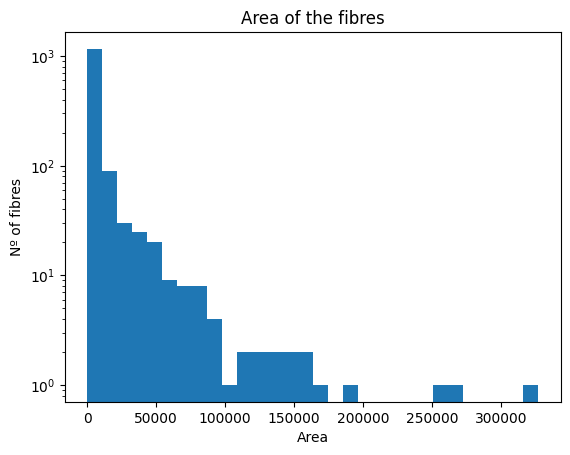

In [19]:
vidrio_area_anns = [ann['area'] for ann in vidrio.loadAnns(vidrio.getAnnIds())]
plt.hist(vidrio_area_anns, bins=30, log=True)
plt.xlabel('Area')
plt.ylabel('Nº of fibres')
plt.title('Area of the fibres')
plt.show()

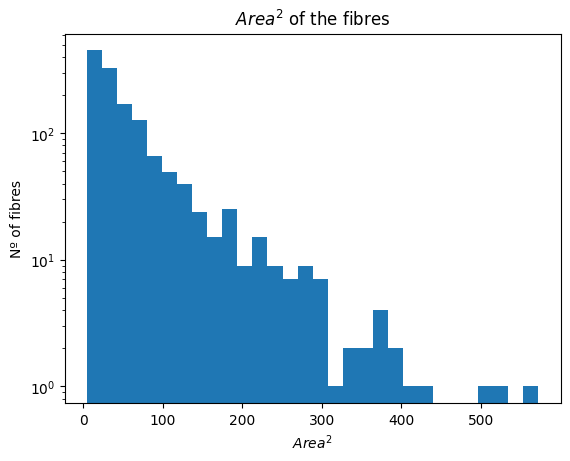

In [20]:
vidrio_area_squrd_anns = [ann['area']**0.5 for ann in vidrio.loadAnns(vidrio.getAnnIds())]
plt.hist(vidrio_area_squrd_anns, bins=30, log=True)
plt.xlabel('$Area^2$')
plt.ylabel('Nº of fibres')
plt.title('$Area^2$ of the fibres')
plt.show()

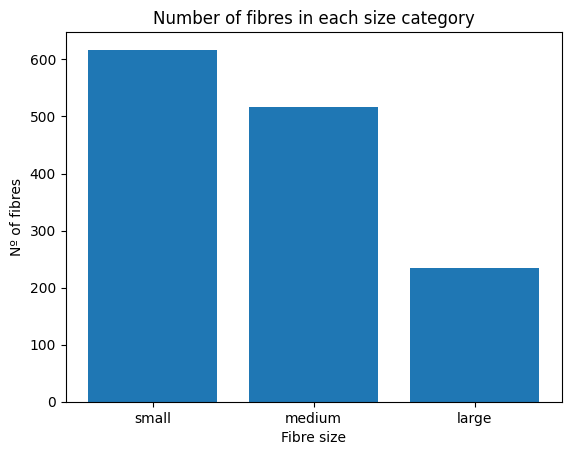

In [21]:
# Given that objects are small if their area < 32^2, medium if 32^2 < area < 96^2, and large if area > 96^2, we can plot the number of annotations in each category
small = 0
medium = 0
large = 0
for ann in vidrio.loadAnns(vidrio.getAnnIds()):
    if ann['area'] < 32**2:
        small += 1
    elif ann['area'] < 96**2:
        medium += 1
    else:
        large += 1

plt.bar(['small', 'medium', 'large'], [small, medium, large])
plt.xlabel('Fibre size')
plt.ylabel('Nº of fibres')
plt.title('Number of fibres in each size category')
plt.show()

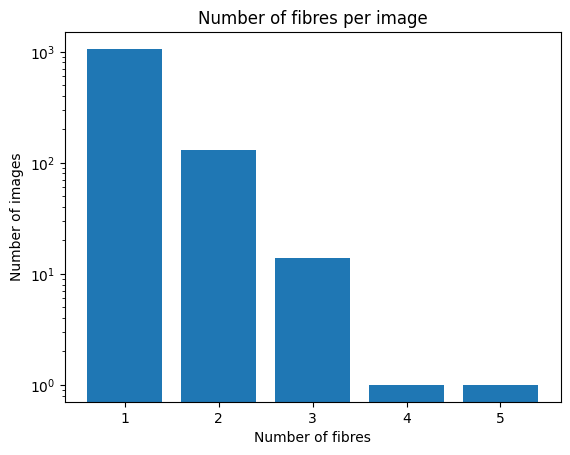

In [22]:
# Plot the number of annotations per image
anns_per_image = [len(vidrio.getAnnIds(imgIds=[img_id])) for img_id in vidrio.getImgIds()]
anns_count = [anns_per_image.count(i) for i in range(1, 6)]
plt.bar(range(1, 6), anns_count, log=True)
plt.xlabel('Number of fibres')
plt.ylabel('Number of images')
plt.title('Number of fibres per image')
plt.show()

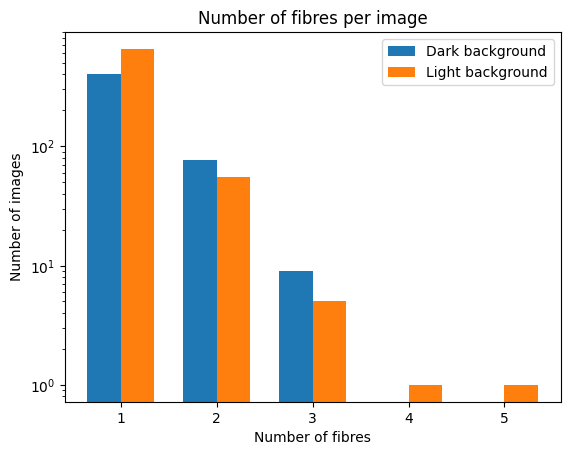

In [23]:
anns_per_image_cat1 = [len(vidrio.getAnnIds(imgIds=[img_id], catIds=[1])) for img_id in vidrio.getImgIds(catIds=[1])]
anns_per_image_cat2 = [len(vidrio.getAnnIds(imgIds=[img_id], catIds=[2])) for img_id in vidrio.getImgIds(catIds=[2])]

anns_count_cat1 = [anns_per_image_cat1.count(i) for i in range(1, 6)]
anns_count_cat2 = [anns_per_image_cat2.count(i) for i in range(1, 6)]

bar_width = 0.35
x = np.arange(1, 6)

plt.bar(x - bar_width/2, anns_count_cat1, width=bar_width, label='Dark background', log=True)
plt.bar(x + bar_width/2, anns_count_cat2, width=bar_width, label='Light background', log=True)

plt.xlabel('Number of fibres')
plt.ylabel('Number of images')
plt.title('Number of fibres per image')
plt.xticks(x)
plt.legend()
plt.show()

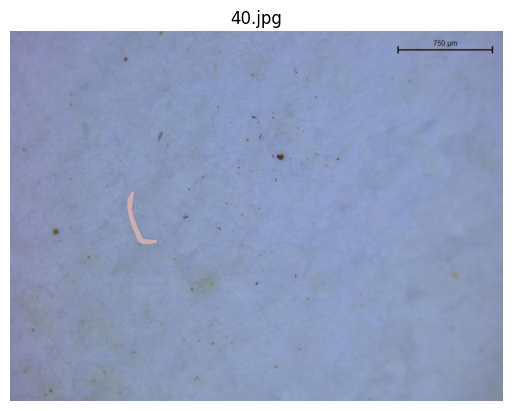

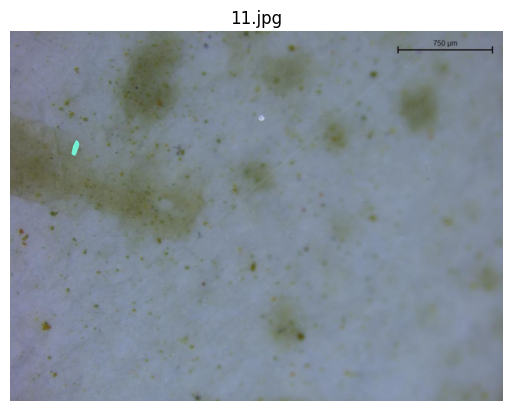

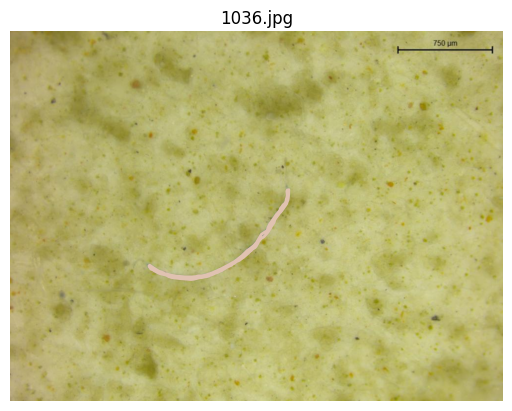

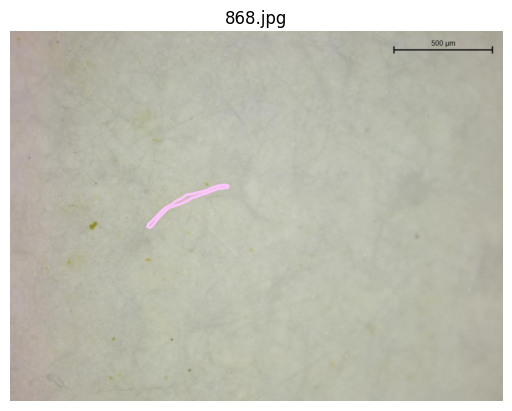

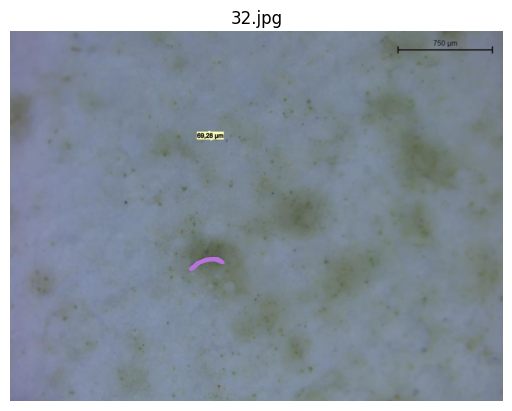

In [24]:
plot_images_with_annotations(vidrio_images_path, vidrio, n_images=5)

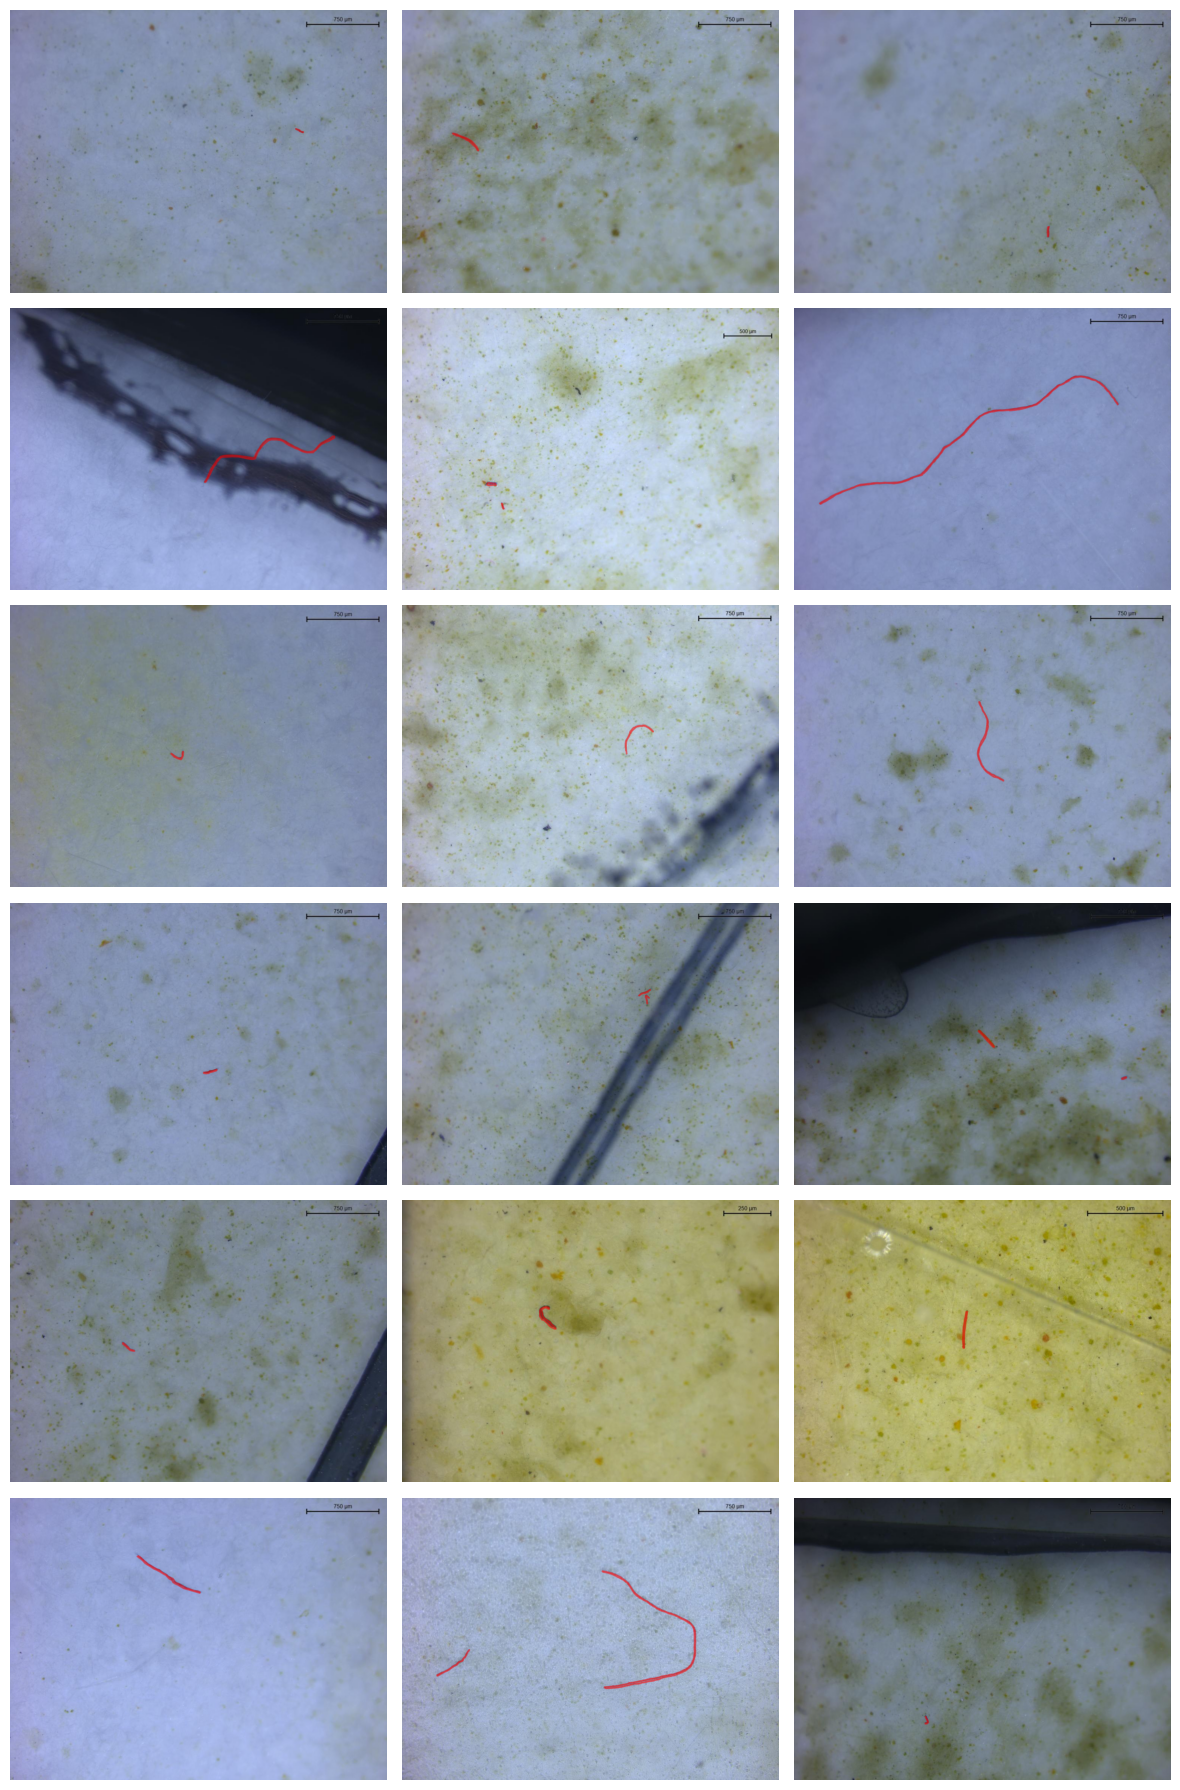

In [25]:
plot_images_with_annotations_grid(vidrio_images_path, vidrio, figsize=(12,18))

# Combination of both Datasets

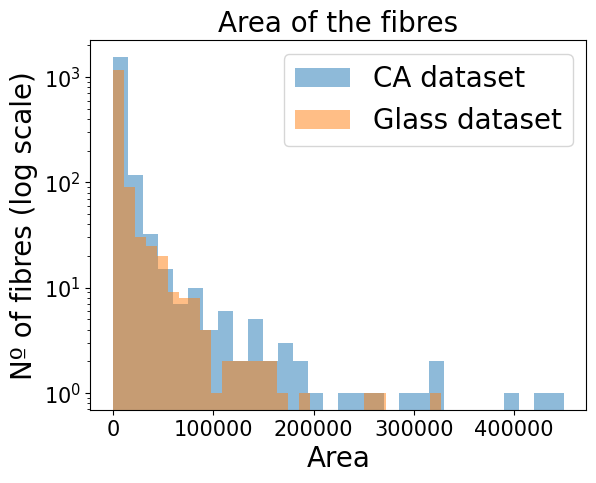

In [26]:
# Plot ca_area_anns and vidrio_area_anns in the same plot
plt.hist(ca_area_anns, bins=30, log=True, alpha=0.5, label='CA dataset')
plt.hist(vidrio_area_anns, bins=30, log=True, alpha=0.5, label='Glass dataset')
plt.xlabel('Area', fontsize=20)
plt.ylabel('Nº of fibres (log scale)', fontsize=20)
plt.title('Area of the fibres', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

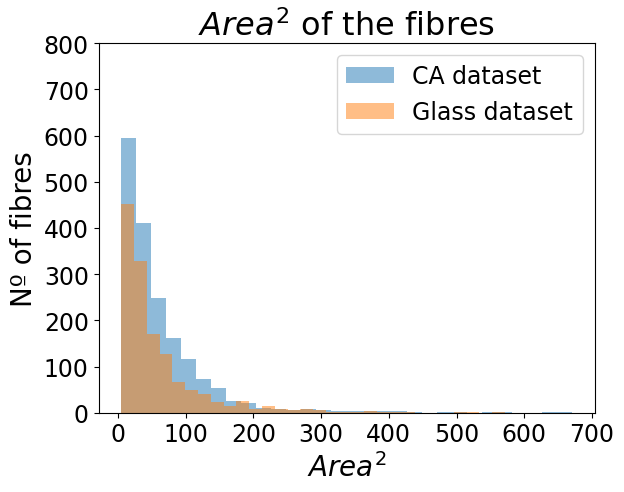

In [27]:
# Plot ca_area_squrd_anns and vidrio_area_squrd_anns in the same plot
plt.hist(ca_area_squrd_anns, bins=30, alpha=0.5, label='CA dataset')
plt.hist(vidrio_area_squrd_anns, bins=30, alpha=0.5, label='Glass dataset')
plt.xlabel('$Area^2$', fontsize=20)
plt.ylabel('Nº of fibres', fontsize=20)
plt.title('$Area^2$ of the fibres', fontsize=23)
plt.legend(fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(0, 800)
plt.ticklabel_format(style='plain', axis='x')
plt.savefig('../plots/all_area_squared_of_objects.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
plt.rcParams['ytick.labelsize'] = 17

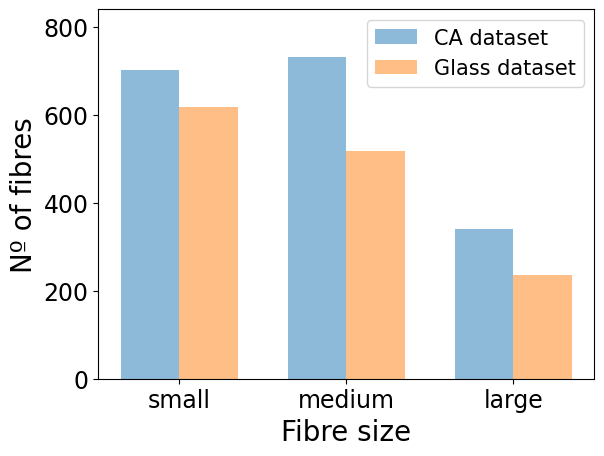

In [29]:
# Plot the number of annotations per image per category (small, medium, large) for both datasets in the same plot
small_ca = 0
medium_ca = 0
large_ca = 0
for ann in ca.loadAnns(ca.getAnnIds()):
    if ann['area'] < 32**2:
        small_ca += 1
    elif ann['area'] < 96**2:
        medium_ca += 1
    else:
        large_ca += 1

small_vidrio = 0
medium_vidrio = 0
large_vidrio = 0
for ann in vidrio.loadAnns(vidrio.getAnnIds()):
    if ann['area'] < 32**2:
        small_vidrio += 1
    elif ann['area'] < 96**2:
        medium_vidrio += 1
    else:
        large_vidrio += 1

bar_width = 0.35
x = np.arange(3)

plt.bar(x - bar_width/2, [small_ca, medium_ca, large_ca], width=bar_width, label='CA dataset', color="#8ebad9")
plt.bar(x + bar_width/2, [small_vidrio, medium_vidrio, large_vidrio], width=bar_width, label='Glass dataset', color="#ffbe86")

plt.xlabel('Fibre size', fontsize=20)
plt.ylabel('Nº of fibres', fontsize=20)
#plt.title('Number of fibres per size category', fontsize=23)

plt.xticks(x, ['small', 'medium', 'large'], fontsize=17)
plt.legend(fontsize=15)
plt.ylim(0, 840)
#plt.yticks(fontsize=17)
#plt.tick_params(axis='y', labelsize=17)

#for label in plt.gca().get_yticklabels():
#    label.set_fontsize(17)
plt.savefig('../plots/all_size_category.png', bbox_inches='tight', dpi=300)
plt.show()

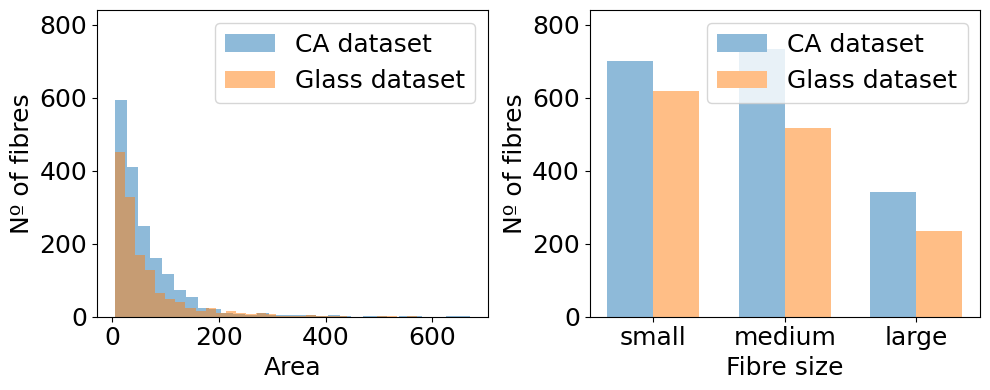

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Subfigure 1: Histogram of $Area^2$
axes[0].hist(ca_area_squrd_anns, bins=30, alpha=0.5, label='CA dataset')
axes[0].hist(vidrio_area_squrd_anns, bins=30, alpha=0.5, label='Glass dataset')
axes[0].set_xlabel('Area', fontsize=18)
axes[0].set_ylabel('Nº of fibres', fontsize=18)
#axes[0].set_title('$Area^2$ of the fibres', fontsize=18)
axes[0].legend(fontsize=18)
axes[0].tick_params(axis='both', labelsize=18)
axes[0].set_ylim(0, 840)
axes[0].ticklabel_format(style='plain', axis='x')

# Subfigure 2: Bar plot of fibre size categories
bar_width = 0.35
x = np.arange(3)
axes[1].bar(x - bar_width/2, [small_ca, medium_ca, large_ca], width=bar_width, label='CA dataset', color="#8ebad9")
axes[1].bar(x + bar_width/2, [small_vidrio, medium_vidrio, large_vidrio], width=bar_width, label='Glass dataset', color="#ffbe86")
axes[1].set_xlabel('Fibre size', fontsize=18)
axes[1].set_ylabel('Nº of fibres', fontsize=18)
#axes[1].set_title('Number of fibres per size category', fontsize=18)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['small', 'medium', 'large'], fontsize=18)
axes[1].legend(fontsize=18)
axes[1].tick_params(axis='both', labelsize=18)
axes[1].set_ylim(0, 840)

plt.tight_layout()
plt.savefig('../plots/combined_figure.png', bbox_inches='tight', dpi=300)
plt.show()


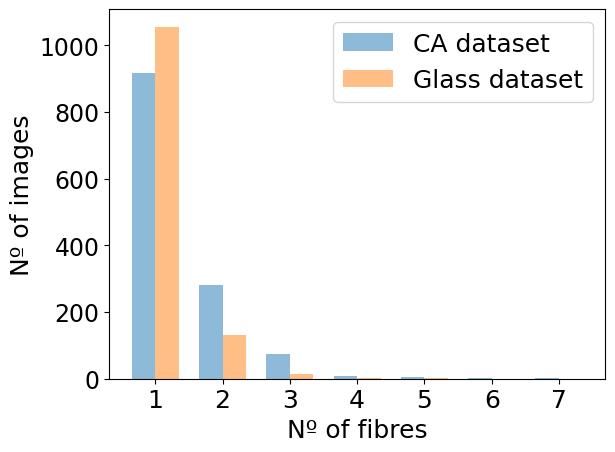

In [31]:
# Plot the number of annotations per image for both datasets
anns_per_image_ca = [len(ca.getAnnIds(imgIds=[img_id])) for img_id in ca.getImgIds()]
anns_count_ca = [anns_per_image_ca.count(i) for i in range(1, 8)]

anns_per_image_vidrio = [len(vidrio.getAnnIds(imgIds=[img_id])) for img_id in vidrio.getImgIds()]
anns_count_vidrio = [anns_per_image_vidrio.count(i) for i in range(1, 8)]

bar_width = 0.35
x = np.arange(1, 8)

plt.bar(x - bar_width/2, anns_count_ca, width=bar_width, label='CA dataset', color="#8ebad9")
plt.bar(x + bar_width/2, anns_count_vidrio, width=bar_width, label='Glass dataset', color="#ffbe86")

plt.xlabel('Nº of fibres', fontsize=18)
plt.ylabel('Nº of images', fontsize=18)
#plt.title('Number of fibres per image', fontsize=18)
plt.xticks(x, fontsize=18)
plt.legend(fontsize=18)
plt.savefig('../plots/all_number_of_fibres_per_image.png', bbox_inches='tight', dpi=300)
plt.show()

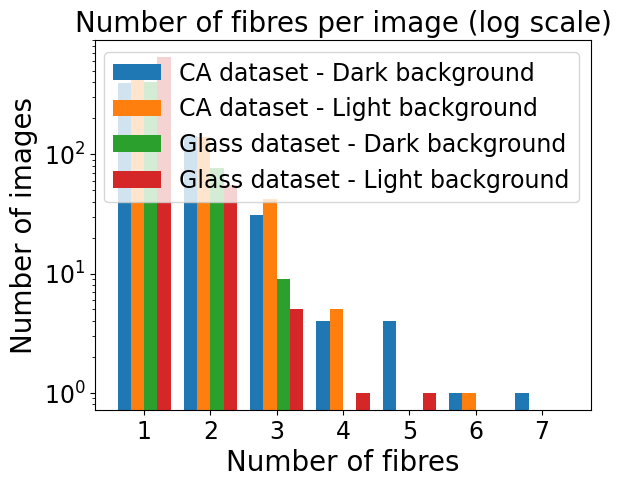

In [32]:
# Plot the number of annotations per image for both datasets
anns_per_image_ca_cat1 = [len(ca.getAnnIds(imgIds=[img_id], catIds=[1])) for img_id in ca.getImgIds(catIds=[1])]
anns_per_image_ca_cat2 = [len(ca.getAnnIds(imgIds=[img_id], catIds=[2])) for img_id in ca.getImgIds(catIds=[2])]
anns_count_ca_cat1 = [anns_per_image_ca_cat1.count(i) for i in range(1, 8)]
anns_count_ca_cat2 = [anns_per_image_ca_cat2.count(i) for i in range(1, 8)]

anns_per_image_vidrio_cat1 = [len(vidrio.getAnnIds(imgIds=[img_id], catIds=[1])) for img_id in vidrio.getImgIds(catIds=[1])]
anns_per_image_vidrio_cat2 = [len(vidrio.getAnnIds(imgIds=[img_id], catIds=[2])) for img_id in vidrio.getImgIds(catIds=[2])]
anns_count_vidrio_cat1 = [anns_per_image_vidrio_cat1.count(i) for i in range(1, 8)]
anns_count_vidrio_cat2 = [anns_per_image_vidrio_cat2.count(i) for i in range(1, 8)]

bar_width = 0.2
x = np.arange(1, 8)

plt.bar(x - 1.5 * bar_width, anns_count_ca_cat1, width=bar_width, label='CA dataset - Dark background', log=True)
plt.bar(x - 0.5 * bar_width, anns_count_ca_cat2, width=bar_width, label='CA dataset - Light background', log=True)
plt.bar(x + 0.5 * bar_width, anns_count_vidrio_cat1, width=bar_width, label='Glass dataset - Dark background', log=True)
plt.bar(x + 1.5 * bar_width, anns_count_vidrio_cat2, width=bar_width, label='Glass dataset - Light background', log=True)

plt.xlabel('Number of fibres', fontsize=20)
plt.ylabel('Number of images', fontsize=20)
plt.title('Number of fibres per image (log scale)', fontsize=20)
plt.xticks(x, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)
plt.show()